In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import osmnx as ox

# RAIL

### Import station name from TfL feed, joined spatially

In [3]:
# # Download station location live feed from TFL
# import urllib.request, json

# try:
#     url = "https://api.tfl.gov.uk/stationdata/tfl-stationdata-detailed.zip"

#     hdr ={
#     # Request headers
#     }

#     req = urllib.request.Request(url, headers=hdr)

#     req.get_method = lambda: 'GET'
#     response = urllib.request.urlopen(req)
#     # download
#     with open('data/tfl-stationdata-detailed.zip', 'wb') as f:
#         f.write(response.read())
        
# except Exception as e:
#     print(e)

# # unzip the file
# import zipfile
# with zipfile.ZipFile('data/tfl-stationdata-detailed.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/tfl-stationdata-detailed') 


<urlopen error [SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1000)>


In [4]:
# # read Stations.csv
# stations = pd.read_csv('data/tfl-stationdata-detailed/Stations.csv')
# stations.head()

# # read StationPoints.csv
# station_pt = pd.read_csv('data/tfl-stationdata-detailed/StationPoints.csv')
# station_pt.head()

In [ ]:
# # Iterate through UniqueId from stations df, and extract mean lat and lon from station_pt df
# for station in stations.UniqueId:
#     lat = station_pt[station_pt.StationUniqueId==station].Lat.mean()
#     lon = station_pt[station_pt.StationUniqueId==station].Lon.mean()
#     # update stations df
#     stations.loc[stations.UniqueId==station, 'Lat'] = lat
#     stations.loc[stations.UniqueId==station, 'Lon'] = lon
#     # geo data frame
#     stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations['Lon'], stations['Lat']), crs='EPSG:4326')

# # drop columns
# stations = stations[['UniqueId', 'Name', 'geometry']]
# stations.info()

In [8]:
# change to dataframe
# stations_df = pd.DataFrame(stations)
# # Export stations
# stations_df.to_csv('data/stations_geo.csv', index=False)

### Import NUMBAT

In [9]:
# # read numbat data
# file = os.path.join('data', 'numbat','numbat_outputs','NBT22SAT_Outputs.csv')
# numbat = pd.read_csv(file)
# numbat.info()

Merging Hub stations

In [10]:
# # extract rows that contain LU, LO DLR, NR, EL in the Station column but not Bethnal Green and West Hampstead
# numbat_hub = numbat[~numbat['Station'].str.contains('Bethnal Green|West Hampstead', regex=True)]
# numbat_hub = numbat_hub[numbat_hub['Station'].str.contains('LU|LO|DLR|NR|EL', regex=True)]
# #create new column with Station value minus 3 characters to the right,trim space
# numbat_hub['Station_hub'] = numbat_hub['Station'].str[:-3].str.strip()
# print(numbat_hub.shape)

# #group by Station_hub and sum the values
# numbat_hub = numbat_hub.groupby('Station_hub').sum().reset_index()
# # #drop Station column, rename Station_hub to Station
# numbat_hub = numbat_hub.rename(columns={'Station':'Old_Station'})
# numbat_hub = numbat_hub.rename(columns={'Station_hub':'Station'})
# print(numbat_hub.shape)

# # Filter numbat for Station without LU, LO DLR, NR, EL in the Station column or if contains Bethnal Green or West Hampstead
# numbat_nonhub = numbat[~numbat['Station'].str.contains('LU|LO|DLR|NR|EL', regex=True)]
# print(numbat_nonhub.shape)
# numbat_nonhub_bth_west = numbat[numbat['Station'].str.contains('Bethnal Green|West Hampstead', regex=True)]
# print(numbat_nonhub_bth_west.shape)

# # concatenate numbat_hub and numbat_new
# numbat_merge = pd.concat([numbat_hub, numbat_nonhub, numbat_nonhub_bth_west], axis=0)
# # remove LU from Station column
# numbat_merge['Station'] = numbat_merge['Station'].str.replace('LU', '')
# print(numbat_merge.shape)

In [11]:
# # Explore merged numbat
# numbat_merge.to_csv('data/numbat_merge.csv', index=False)

### Import merged  file, reconciled NUMBAT + STATION LOCATIONS

In [36]:
from shapely import wkt

df = pd.read_csv(os.path.join('data','numbat_geom_sat_exit.csv'), delimiter=',')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='epsg:4326') # convert to geodataframe
gdf.to_crs(epsg=27700, inplace=True) # convert to British National Grid

In [37]:
# gdf.explore()

In [38]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   nlc          432 non-null    int64   
 1   asc          432 non-null    object  
 2   stationname  432 non-null    object  
 3   geometry     432 non-null    geometry
 4   Total        432 non-null    int64   
 5   Early        432 non-null    int64   
 6   AM Peak      432 non-null    int64   
 7   Midday       432 non-null    int64   
 8   PM Peak      432 non-null    int64   
 9   Evening      432 non-null    int64   
 10  Late         432 non-null    int64   
dtypes: geometry(1), int64(8), object(2)
memory usage: 37.3+ KB


In [39]:
# download the Greater London boundary
greater_london = ox.geocode_to_gdf('Greater London, UK')
greater_london.to_crs(epsg=27700, inplace=True)

# subset points that are within the boundary of london
gdf = gdf[gdf.geometry.intersects(greater_london.geometry[0])]
gdf.reset_index(drop=True,inplace=True)

#400 stations are within the Greater London boundary'

In [41]:
gdf.explore()

Text(0.5, 1.0, 'Total Exit flow - TfL Rail')

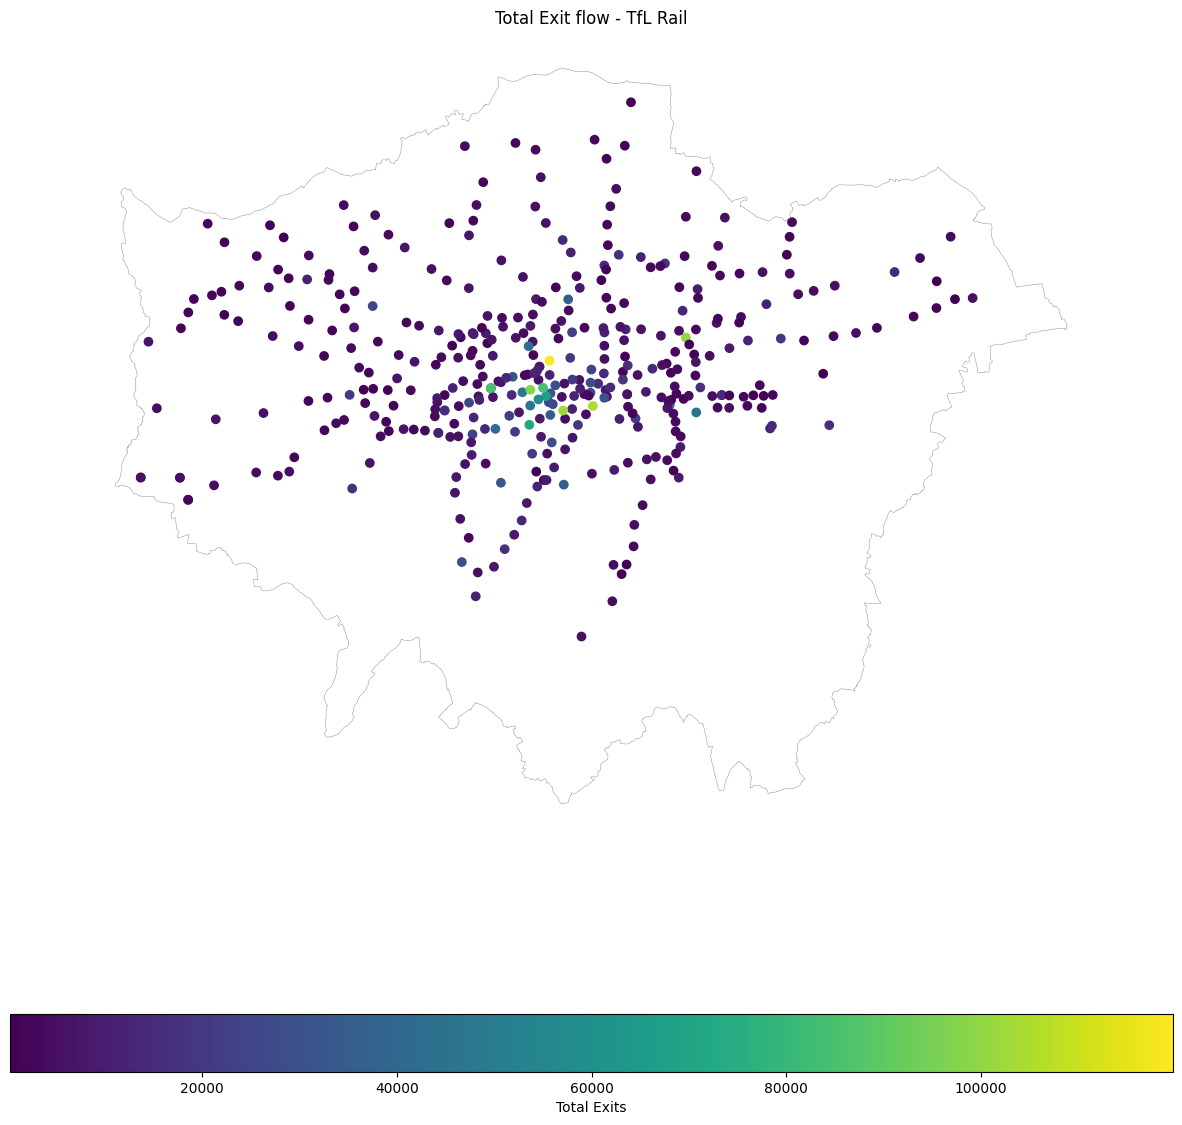

In [42]:
# plot stations_numbat_geo based on Total

fig,ax = plt.subplots(1,1,figsize=(15,15))
gdf.plot(column='Total',ax=ax,legend=True,legend_kwds={'label': "Total Exits",'orientation': "horizontal"})
greater_london.boundary.plot(ax=ax, color='grey', linewidth=0.3)
ax.set_axis_off()
plt.title('Total Exit flow - TfL Rail')

In [43]:
# Export stations_numbat_geo TO GEOJSON ESPG:27700
gdf.to_file('data/cleaned/flow_rail.geojson', driver='GeoJSON')